# Dre Reverberation Algorithm

Graphic representation of the processing for the left channel, right channel vice versa, based on Wavefront semiconductor AN3201 Application Note. Input data is a 16bit, 44.1kHz impulse response.

<img align="center" width=80% src="dre_reverb_block.png" alt>

In [2]:
from math import pi
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import wavio
import IPython

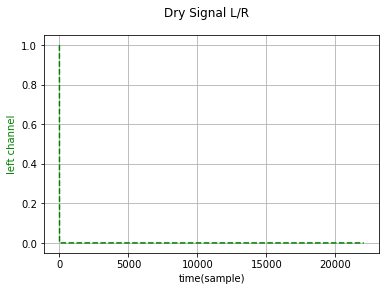

In [3]:
sr = 44100

wav = wavio.read("dirac16_44_stereo.wav")

left_channel = wav.data[:, 0]
left_channel = left_channel.astype(np.float32, order='C') / 32767.0

x_axis = np.arange(len(left_channel))

plt.figure(1)
plt.suptitle('Dry Signal L/R')

plt.subplot(111)
plt.plot(x_axis, left_channel, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

In [7]:
left_input = left_channel

time = np.array([1, 955, 1055, 1699, 1867, 1987, 3055, 3321])

gain = np.array([0.5, 0.45, 0.06, 0.4, 0.3, 0.3, 0.13, 0.12])

sample = np.around(time).astype(int)

numerator = np.zeros(int(sample[-1])+1)
denominator = 1

for i in range(0, len(sample)):
    numerator[sample[i]] = gain[i]
    
left_tdl_output  = scipy.signal.lfilter(numerator, denominator, left_input)

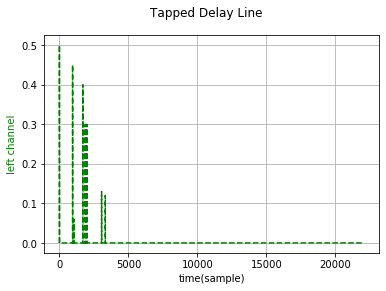

In [8]:
x_axis = np.arange(len(left_tdl_output))

plt.figure(1)
plt.suptitle('Tapped Delay Line')

plt.subplot(111)
plt.plot(x_axis, left_tdl_output, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

In [10]:
lbcf_delaylist = np.array([2200, 2926, 2956, 3744])
roomsize = np.array([0.45, 0.49, 0.52, 0.39])
damp = np.array([0.45, 0.42, 0.39, 0.36])

left_lbcf_output = []

for i in range(len(lbcf_delaylist)):
    delaysample = lbcf_delaylist[i]
    arraysize = delaysample + 1

    numerator = np.zeros(arraysize + 1)
    denominator = np.zeros(arraysize)

    numerator[arraysize-1] = 1
    numerator[arraysize] = -damp[i]

    denominator[0] = 1
    denominator[1] = -damp[i]
    denominator[arraysize-1] = -roomsize[i]*(1-damp[i])

    left_ch = scipy.signal.lfilter(numerator, denominator, left_tdl_output)
    left_lbcf_output.append(left_ch)
    
left_lbcf_output = sum(left_lbcf_output)
left_lbcf_output = left_lbcf_output/len(lbcf_delaylist)

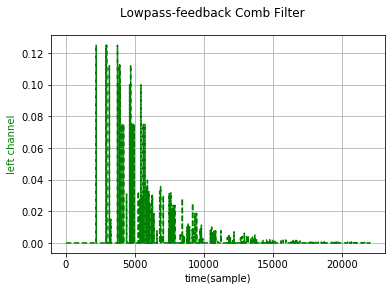

In [11]:
x_axis = np.arange(len(left_lbcf_output))

plt.figure(1)
plt.suptitle('Lowpass-feedback Comb Filter')

plt.subplot(111)
plt.plot(x_axis, left_lbcf_output, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

In [12]:
g = 0.7
apf_delaylist = np.array([1201])

for i in range(len(apf_delaylist)):
    delaysample = apf_delaylist[i]
    arraysize = delaysample+1

    numerator = np.zeros(arraysize)
    denominator = np.zeros(arraysize)
    
    numerator[0] = -g
    numerator[delaysample] = 1

    denominator[0] = 1
    denominator[delaysample] = -g
    
    left_apf_output = scipy.signal.lfilter(numerator, denominator, left_lbcf_output)

In [13]:
unit_tdl_output = wavio.read("unit_tdl_output.wav")
unit_tdl_output = unit_tdl_output.data[:, 0]
unit_tdl_output = unit_tdl_output.astype(np.float32, order='C') / 32767.0

unit_lbcf_output = wavio.read("unit_lbcf_output.wav")
unit_lbcf_output = unit_lbcf_output.data[:, 0]
unit_lbcf_output = unit_lbcf_output.astype(np.float32, order='C') / 32767.0

unit_apf_output = wavio.read("unit_apf_output.wav")
unit_apf_output = unit_apf_output.data[:, 0]
unit_apf_output = unit_apf_output.astype(np.float32, order='C') / 32767.0

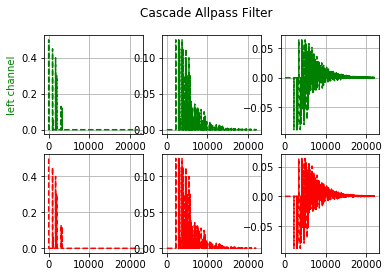

In [14]:
x_axis = np.arange(len(left_apf_output))

plt.figure(1)
plt.suptitle('Cascade Allpass Filter')

plt.subplot(231)
plt.plot(x_axis, left_tdl_output, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.subplot(232)
plt.plot(x_axis, left_lbcf_output, 'g--')
plt.grid()

plt.subplot(233)
plt.plot(x_axis, left_apf_output, 'g--')
plt.grid()

plt.subplot(234)
plt.plot(x_axis, unit_tdl_output, 'r--')
plt.grid()

plt.subplot(235)
plt.plot(x_axis, unit_lbcf_output, 'r--')
plt.grid()

plt.subplot(236)
plt.plot(x_axis, unit_apf_output, 'r--')
plt.grid()

plt.show()

In [15]:
tdl_err = np.zeros(len(x_axis))
lbcf_err = np.zeros(len(x_axis))
apf_err = np.zeros(len(x_axis))


for i in range(len(x_axis)):
    tdl_err[i] = left_tdl_output[i] - unit_tdl_output[i]
    lbcf_err[i] = left_lbcf_output[i] - unit_lbcf_output[i]
    apf_err[i] = left_apf_output[i] - unit_apf_output[i]

print("tdl err(%):", np.sum(tdl_err)/len(x_axis)*100)
print("lbcf err(%):", np.sum(lbcf_err)/len(x_axis)*100)
print("apf err(%):", np.sum(apf_err)/len(x_axis)*100)

tdl err(%): 1.9649529403033145e-07
lbcf err(%): 0.00035402783891181765
apf err(%): 0.0003126992479958723


In [16]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

x = left_apf_output.reshape(-1, 1)
y = unit_apf_output.reshape(-1, 1)

d, paths = dtw.warping_paths(x, y, window=100, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(x, y, paths, best_path)

ModuleNotFoundError: No module named 'dtaidistance'